# Risk Estimation

### Setup

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Ignorar todos los warnings
warnings.filterwarnings('ignore')
sns.set(style='darkgrid', palette='deep')

In [44]:
# Paths

root_path = "../"
data_path = os.path.join(root_path, "data/")
historical_data_path = os.path.join(data_path, "Historicos.csv")
current_data_path = os.path.join(data_path, "Vigentes.csv")

output_data_path = os.path.join(data_path, "risk_probabilities.xlsx")

### Import Data

In [45]:
df = pd.read_csv(historical_data_path)

In [46]:
df.head()

,ID,education,city,monthly_income,current_assets,credit_score,Monto,paid_in_full,loss
0,3822088719,undergraduate,Medellin,11474.07,40530.37,611,"$ 6,599,489",0,$ 0
1,5431270632,phd,Medellin,16686.98,61403.51,765,"$ 7,466,025",1,"$ 5,606,767"
2,2919928231,undergraduate,Cali,9928.97,51321.42,542,"$ 13,410,229",0,$ 0
3,3952534684,undergraduate,Bucaramanga,11331.48,23544.06,619,"$ 17,369,018",1,"$ 9,059,520"
4,5160944656,phd,Bogota,10146.78,27220.55,654,"$ 2,493,060",0,$ 0


### EDA

Tipos de datos

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              700 non-null    int64  
 1   education       700 non-null    object 
 2   city            700 non-null    object 
 3   monthly_income  700 non-null    float64
 4   current_assets  700 non-null    float64
 5   credit_score    700 non-null    int64  
 6   Monto           700 non-null    object 
 7   paid_in_full    700 non-null    int64  
 8   loss            700 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 49.3+ KB


In [48]:
df.columns

Index(['ID', 'education', 'city', 'monthly_income', 'current_assets',
       'credit_score', 'Monto', 'paid_in_full', 'loss'],
      dtype='object')

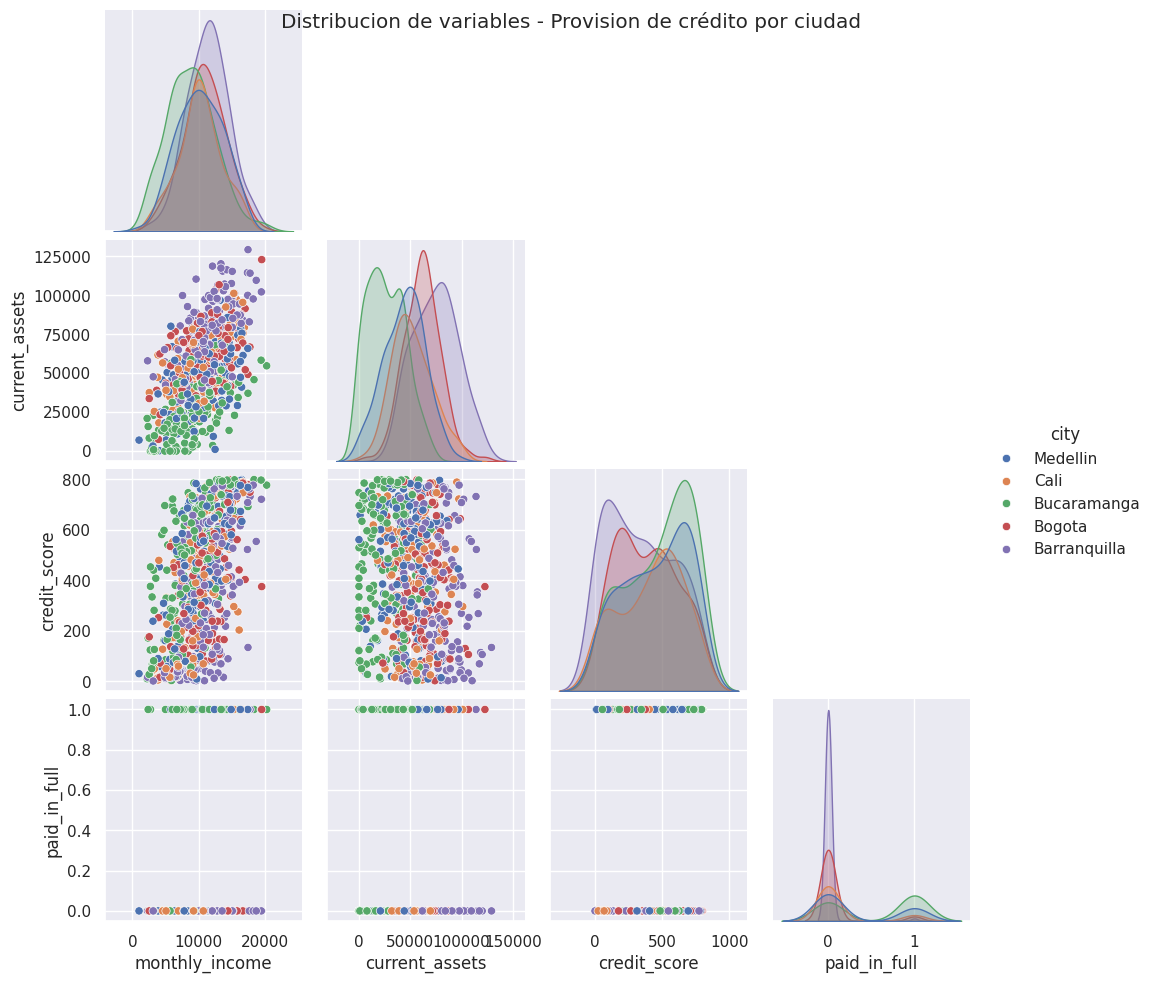

In [49]:
sns.pairplot(data=df[['city', 'monthly_income', 'current_assets','credit_score', 'Monto', 'paid_in_full', 'loss']], corner=True, hue="city")
plt.suptitle("Distribucion de variables - Provision de crédito por ciudad")
plt.savefig("../images/city_level_loans.png", format="png")
plt.show()

In [100]:
approvals_df = df[["city", "ID"]].groupby("city").count()
payments_df = df[["city", "paid_in_full"]].groupby("city").mean()
score_df = df[["city", "credit_score"]].groupby("city").mean()

join1 = approvals_df.join(payments_df, on="city", how="inner")
city_df = join1.join(score_df, on="city", how="inner")

In [101]:
city_df

,ID,paid_in_full,credit_score
city,,,
Barranquilla,165,0.012121,338.218182
Bogota,133,0.060150,385.097744
Bucaramanga,156,0.576923,481.230769
Cali,110,0.145455,414.963636
Medellin,136,0.323529,451.264706


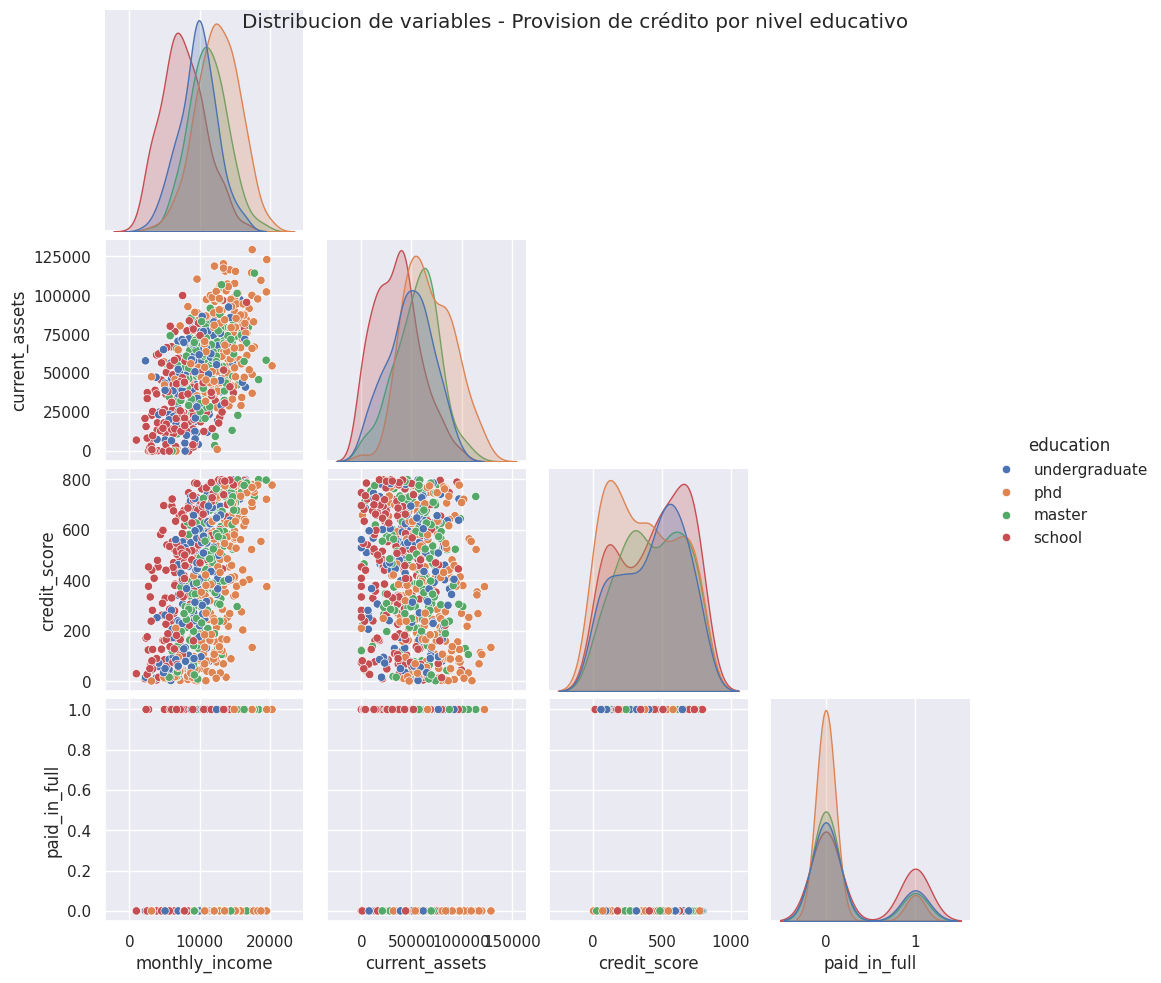

In [110]:
sns.pairplot(data=df[['education', 'monthly_income', 'current_assets','credit_score', 'Monto', 'paid_in_full', 'loss']], corner=True, hue="education")
plt.suptitle("Distribucion de variables - Provision de crédito por nivel educativo")
plt.savefig("../images/education_level_loans.png", format="png")
plt.show()

In [115]:
# correlation between education level and loan success
df[["education", "paid_in_full"]].groupby("education").mean()

,paid_in_full
education,
master,0.203822
phd,0.110000
school,0.368984
undergraduate,0.237179


In [118]:
# correlation between education level and loan success by city
df[["education", "city", "paid_in_full"]].groupby(["education", "city"]).mean().sort_values(by="paid_in_full")

paid_in_full
education     city                      
school        Barranquilla      0.000000
undergraduate Barranquilla      0.000000
school        Bogota            0.000000
undergraduate Bogota            0.000000
phd           Barranquilla      0.008929
master        Barranquilla      0.028571
              Bogota            0.076923
school        Cali              0.095238
phd           Bogota            0.104167
master        Cali              0.147059
school        Medellin          0.155556
phd           Cali              0.157895
undergraduate Cali              0.166667
              Medellin          0.315789
master        Medellin          0.416667
undergraduate Bucaramanga       0.542857
school        Bucaramanga       0.576923
phd           Medellin          0.588235
master        Bucaramanga       0.615385
phd           Bucaramanga       0.750000

### Data Preprocessing

In [104]:
df_processed = df.copy()

df_processed.drop("ID", axis=1, inplace=True)

# Convert to numerical
df_processed["city"] = pd.factorize(values=df_processed["city"])[0]
df_processed["education"] = pd.factorize(values=df_processed["education"])[0]

In [52]:
df_processed.head()

,education,city,monthly_income,current_assets,credit_score,Monto,paid_in_full,loss
0,0,0,11474.07,40530.37,611,"$ 6,599,489",0,$ 0
1,1,0,16686.98,61403.51,765,"$ 7,466,025",1,"$ 5,606,767"
2,0,1,9928.97,51321.42,542,"$ 13,410,229",0,$ 0
3,0,2,11331.48,23544.06,619,"$ 17,369,018",1,"$ 9,059,520"
4,1,3,10146.78,27220.55,654,"$ 2,493,060",0,$ 0


### Modeling

In [53]:
from sklearn.preprocessing import StandardScaler  # Scalar las variables para darles la misma importancia en el modelamiento
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

In [54]:
# Limpiar la columna "Monto" eliminando los signos de dólar y las comas
df_processed['Monto'] = df_processed['Monto'].replace({'\$': '', ',': ''}, regex=True)

# Convertir la columna "Monto" a tipo float
df_processed['Monto'] = df_processed['Monto'].astype(float)

# Verificar el resultado
print(df_processed['Monto'].head())


0     6599489.0
1     7466025.0
2    13410229.0
3    17369018.0
4     2493060.0
Name: Monto, dtype: float64


In [55]:
# Split data between input and output variables

output_variable = "paid_in_full"
input_cols = list(df_processed.drop([output_variable, "loss"], axis=1).columns)
output_cols = [output_variable]

X = df_processed[input_cols]
y = df_processed[output_cols]

scaler = StandardScaler()
X = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)

In [56]:
model = LogisticRegressionCV(cv=5, random_state=42)
model.fit(X, y)

LogisticRegressionCV(cv=5, random_state=42)

In [57]:
paid_in_full_likelihood = model.predict_proba(X)


In [58]:
df_processed["paid_in_full_likelihood"] = paid_in_full_likelihood[:, 1]

In [59]:
df_processed.head()

,education,city,monthly_income,current_assets,credit_score,Monto,paid_in_full,loss,paid_in_full_likelihood
0,0,0,11474.07,40530.37,611,6599489.0,0,$ 0,0.301819
1,1,0,16686.98,61403.51,765,7466025.0,1,"$ 5,606,767",0.785426
2,0,1,9928.97,51321.42,542,13410229.0,0,$ 0,0.104639
3,0,2,11331.48,23544.06,619,17369018.0,1,"$ 9,059,520",0.121347
4,1,3,10146.78,27220.55,654,2493060.0,0,$ 0,0.123344


### Export Results

In [60]:
# Predict current credit loans

df_current = pd.read_csv(current_data_path)

In [61]:
df_current.head()

,ID,education,city,monthly_income,current_assets,credit_score,Monto
0,6330126953,school,Cali,8939.64,43688.17,577,"$ 15,559,852"
1,1095851485,master,Bogota,6315.23,48059.17,16,"$ 523,804"
2,1207726431,undergraduate,Cali,13111.08,61617.49,663,"$ 6,340,907"
3,8874502266,undergraduate,Medellin,11469.24,40144.80,694,"$ 14,228,363"
4,4218374299,phd,Barranquilla,7196.54,56586.85,36,"$ 17,492,258"


In [62]:
# Limpiar columna monto

df_current['Monto'] = df_current['Monto'].replace({'\$': '', ',': ''}, regex=True)
df_current['Monto'] = df_current['Monto'].astype(float)

In [63]:
df_current.head()

,ID,education,city,monthly_income,current_assets,credit_score,Monto
0,6330126953,school,Cali,8939.64,43688.17,577,15559852.0
1,1095851485,master,Bogota,6315.23,48059.17,16,523804.0
2,1207726431,undergraduate,Cali,13111.08,61617.49,663,6340907.0
3,8874502266,undergraduate,Medellin,11469.24,40144.80,694,14228363.0
4,4218374299,phd,Barranquilla,7196.54,56586.85,36,17492258.0


In [64]:
df_current.drop("ID", axis=1, inplace=True)

# Convert to numerical
df_current["city"] = pd.factorize(values=df_current["city"])[0]
df_current["education"] = pd.factorize(values=df_current["education"])[0]

In [65]:
X = df_current[input_cols]
X = pd.DataFrame(data=scaler.transform(X), columns=X.columns)  #Solo transformar para prevenir data leakage

In [66]:
df_current["paid_in_full_likelihood"] = model.predict_proba(X)[:, 1]

In [67]:
df_current

,education,city,monthly_income,current_assets,credit_score,Monto,paid_in_full_likelihood
0,0,0,8939.64,43688.17,577,15559852.0,0.120871
1,1,1,6315.23,48059.17,16,523804.0,0.078521
2,2,0,13111.08,61617.49,663,6340907.0,0.656284
3,2,2,11469.24,40144.80,694,14228363.0,0.290368
4,3,3,7196.54,56586.85,36,17492258.0,0.072795
...,...,...,...,...,...,...,...
295,1,3,9033.51,71402.19,173,10312776.0,0.048122
296,0,1,6273.85,59904.20,214,4279734.0,0.037187
297,0,2,9783.13,13710.87,796,13599178.0,0.089391
298,1,1,14829.08,81929.52,718,15478847.0,0.438663


In [68]:
df_current.to_csv(output_data_path)  #TODO: Export in legible COls

In [69]:
import joblib
joblib.dump(model, '../models/risk_model.pkl')

['../models/risk_model.pkl']

### Model Explainability

In [70]:
import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression


def model_predict(x):
    return model.predict_proba(x)

explainer = shap.KernelExplainer(model_predict, X.iloc[:100])  # Usamos una muestra del dataset para el explainer
shap_values = explainer.shap_values(X)

print(f"Forma de shap_values: {len(shap_values)}")

plt.figure()
shap_summary_plot = shap.summary_plot(shap_values[:, :, 0], X, show=False)
plt.title('SHAP Summary Plot')
#plt.plot(shap_summary_plot)
plt.savefig('../images/shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.close()

plt.figure()
shap_dependence_plot = shap.dependence_plot("monthly_income", shap_values[:, :, 0], X, show=False)
plt.title('SHAP Dependence Plot - Monthly Income')
#plt.plot(shap_dependence_plot)
plt.savefig('../images/shap_dependence_plot_monthly_income.png', dpi=300, bbox_inches='tight')
plt.close()


100%|██████████| 300/300 [00:01<00:00, 246.10it/s]


Forma de shap_values: 300


<Figure size 640x480 with 0 Axes>

In [71]:
print("Gráficos guardados como 'shap_summary_plot.png' y 'shap_dependence_plot_monthly_income.png'.")

Gráficos guardados como 'shap_summary_plot.png' y 'shap_dependence_plot_monthly_income.png'.


### Calculo de Provision 

In [ ]:
df_current.head()

,education,city,monthly_income,current_assets,credit_score,Monto,paid_in_full_likelihood
0,0,0,8939.64,43688.17,577,15559852.0,0.120871
1,1,1,6315.23,48059.17,16,523804.0,0.078521
2,2,0,13111.08,61617.49,663,6340907.0,0.656284
3,2,2,11469.24,40144.80,694,14228363.0,0.290368
4,3,3,7196.54,56586.85,36,17492258.0,0.072795


In [ ]:
df_processed["default_prob"] = 1 - df_processed["paid_in_full_likelihood"]
df_current["default_prob"] = 1 - df_processed["paid_in_full_likelihood"]

In [ ]:
df_processed["credit_provision"] = df_processed["Monto"] * df_processed["default_prob"]
df_current["credit_provision"] = df_current["Monto"] * df_current["default_prob"]

In [ ]:
df_current.head()

,education,city,monthly_income,current_assets,credit_score,Monto,paid_in_full_likelihood,default_prob,credit_provision
0,0,0,8939.64,43688.17,577,15559852.0,0.120871,0.698181,1.086360e+07
1,1,1,6315.23,48059.17,16,523804.0,0.078521,0.214574,1.123948e+05
2,2,0,13111.08,61617.49,663,6340907.0,0.656284,0.895361,5.677404e+06
3,2,2,11469.24,40144.80,694,14228363.0,0.290368,0.878653,1.250179e+07
4,3,3,7196.54,56586.85,36,17492258.0,0.072795,0.876656,1.533469e+07


In [ ]:
df_processed.head()

,education,city,monthly_income,current_assets,credit_score,Monto,paid_in_full,loss,paid_in_full_likelihood,default_prob,credit_provision
0,0,0,11474.07,40530.37,611,6599489.0,0,$ 0,0.301819,0.698181,4.607640e+06
1,1,0,16686.98,61403.51,765,7466025.0,1,"$ 5,606,767",0.785426,0.214574,1.602016e+06
2,0,1,9928.97,51321.42,542,13410229.0,0,$ 0,0.104639,0.895361,1.200700e+07
3,0,2,11331.48,23544.06,619,17369018.0,1,"$ 9,059,520",0.121347,0.878653,1.526134e+07
4,1,3,10146.78,27220.55,654,2493060.0,0,$ 0,0.123344,0.876656,2.185555e+06


In [ ]:
historical_loss = df_processed['credit_provision'].sum()
current_credit_prov = df_current['credit_provision'].sum()

In [ ]:
print(f"{'='*40}")
print(f"{'Historical Loss and Current Credit Provision':^40}")
print(f"{'='*40}")
print(f"Historical Loss: ${historical_loss:,.2f}")
print(f"Current Credit Provision: ${current_credit_prov:,.2f}")
print(f"{'='*40}")


Historical Loss and Current Credit Provision
Historical Loss: $5,298,989,927.29
Current Credit Provision: $2,312,186,611.28


In [ ]:
# Statistics

prov_mean = df_processed['credit_provision'].mean()
prov_median = df_processed['credit_provision'].median()

In [ ]:
print(f"{'='*40}")
print(f"{'Credit Provision Statistics':^40}")
print(f"{'='*40}")
print(f"Mean Credit Provision:   ${prov_mean:,.2f}")
print(f"Median Credit Provision: ${prov_median:,.2f}")
print(f"{'='*40}")


      Credit Provision Statistics       
Mean Credit Provision:   $7,569,985.61
Median Credit Provision: $6,624,960.65


In [ ]:
import pandas as pd

# Cálculo de estadísticas
historical_loss = df_processed['credit_provision'].sum()
current_credit_prov = df_current['credit_provision'].sum()
prov_mean = df_processed['credit_provision'].mean()
prov_median = df_processed['credit_provision'].median()

stats_dict = {
    'Statistic': ['Historical Loss', 'Current Credit Provision', 'Mean Credit Provision', 'Median Credit Provision'],
    'Value': [historical_loss, current_credit_prov, prov_mean, prov_median]
}

stats_df = pd.DataFrame(stats_dict)

stats_df

,Statistic,Value
0,Historical Loss,5.298990e+09
1,Current Credit Provision,2.312187e+09
2,Mean Credit Provision,7.569986e+06
3,Median Credit Provision,6.624961e+06


In [ ]:
stats_df.to_csv("../data/final_statistics.csv", index=False)